In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import os
import sys
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.insert(0, os.path.join(parent_dir, 'pysta2'))

import pysta
# import stc
# import stcl

# from stcl import load_centers

import pandas as pd
import os

%load_ext autoreload
%autoreload 2

In [2]:
# helper functions for visualization
def box_off():
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
def p2p(sta):
    return np.max(sta) - np.min(sta)

def psnr(sta):
    return (np.max(sta.ravel()) - np.min(sta.ravel())) / np.std(sta.ravel())

def plot_spatio_temporal(sta, height=13, width=13, dt=1000/30, ylabel=None, fig_basename=None):        
    tap = sta.shape[-1]
    figsize = (5.5,3.5)
    plt.figure(figsize=figsize)
    pysta.plot_temporal_profile(sta, tap, dt, ylim=[-0.5,0.5])
    if ylabel is not None:
        plt.ylabel(ylabel)
    print('peak-to-peak diff. = {:.2f}'.format(p2p(sta)))
    print('PSNR = {:.2f}'.format(psnr(sta)))
#     plt.title('peak diff. = {:.2f}'.format(p2p(sta)))
    plt.xlabel(None)

    if fig_basename is not None:
        plt.savefig(fig_basename + '_temp.pdf', bbox_inches='tight') # https://stackoverflow.com/a/4046233

    plt.figure()
    pysta.plot_stim_slices(sta, height=height, width=width, dt=dt, vmin=-0.5, vmax=0.5)

#     plt.tight_layout()
    
    if fig_basename is not None:
        plt.savefig(fig_basename + '_spatial.pdf', bbox_inches='tight')
    
    
def groupby_dict(df, col, group):
    data = dict()
    for group_val, d in df.groupby(group):
#         print(group_val)
        data[group_val] = d[col].to_list()
    return data


def plot_bar_by_group(info, col, 
                      groupby='cell_type', 
                      group_values = ['ON', 'OFF', 'ON-OFF', 'Unknown'], color=['r','#00A0FF','green', '#A0A0A0']):
    
    means = info.groupby(groupby)[col].mean()[group_values]
    sems = info.groupby(groupby)[col].sem()[group_values]

    plt.bar(group_values, means, yerr=sems,
            width=0.4, color=color, edgecolor='k', linewidth=1,
            capsize=5)
    
    plt.ylabel(col.replace('_', ' '))
    plt.xlabel(groupby.replace('_', ' '))
    
    plt.xlim(-0.5, len(group_values)-0.5)
    box_off()

Let's re-plot old Figure 3 (ON-OFF cell) for all the methods

## load data

In [3]:
# baseline dataset
dataset0 = '8x8 10Hz'

width = 8
height = 8
fps = 10

info0 = pd.read_csv('20180828_{}pix_{}Hz_sta.csv'.format(width,fps))
info0['dataset'] = dataset0

In [4]:
# # different spatial & temporal resolutions (2018.08.28)
# dataset1 = '8x8 25Hz'

# width = 8
# height = 8
# fps = 25

# dataset1 = '13x13 10Hz'

# width = 13
# height = 13
# fps = 10

dataset1 = '26x26 10Hz'

width = 26
height = 26
fps = 10

info1 = pd.read_csv('20180828_{}pix_{}Hz_sta.csv'.format(width,fps))
info1['dataset'] = dataset1

info = pd.concat([info0, info1])

## compare STA p2p

In [5]:
info.groupby('dataset').mean()[['sta_p2p', 'sta_psnr']]

,sta_p2p,sta_psnr
dataset,,
26x26 10Hz,0.226395,12.951088
8x8 10Hz,0.336359,12.408469


In [6]:
info.groupby('dataset').sem()[['sta_p2p', 'sta_psnr']]

,sta_p2p,sta_psnr
dataset,,
26x26 10Hz,0.012179,0.639467
8x8 10Hz,0.018342,0.586505


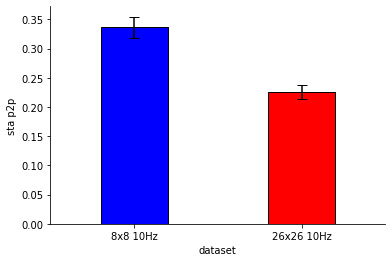

In [7]:
plot_bar_by_group(info, 'sta_p2p',
                  groupby='dataset',
                  group_values = [dataset0, dataset1], color=['b', 'r'])

In [8]:
# test significance: ON or OFF vs. ON/OFF
data = groupby_dict(info, 'sta_p2p', 'dataset')

t, p = stats.ttest_ind(data[dataset0], data[dataset1], equal_var=False)
print(p)

1.4885817795978199e-06


## Compare by cell types

In [9]:
info.groupby(['dataset','cell_type'], sort=False).mean()

sta_p2p   sta_psnr
dataset    cell_type                     
8x8 10Hz   OFF        0.372672  17.239014
           ON         0.421244  15.778832
           Unknown    0.265957   7.192651
26x26 10Hz OFF        0.273742  19.450459
           Unknown    0.182232   7.967625
           ON         0.245490  14.021655

In [10]:
info.groupby(['dataset','cell_type'], sort=False).sem()

channel   sta_p2p  sta_psnr
dataset    cell_type                             
8x8 10Hz   OFF            NaN  0.029878  0.796546
           ON             NaN  0.024581  0.617636
           Unknown        NaN  0.029306  0.328985
26x26 10Hz OFF            NaN  0.022422  1.348955
           Unknown        NaN  0.018445  0.174253
           ON             NaN  0.020175  0.798910

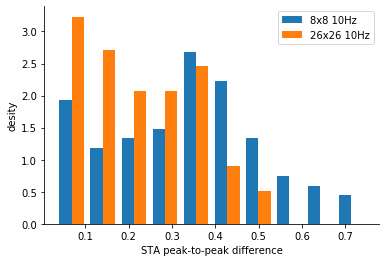

In [11]:
col = 'sta_p2p'
plt.hist([info0[col].tolist(), info1[col].tolist()], density=True)
plt.legend([dataset0, dataset1])
plt.xlabel('STA peak-to-peak difference')
plt.ylabel('desity')
box_off()

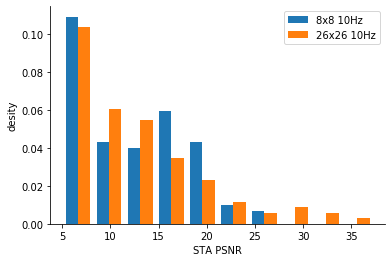

In [12]:
col = 'sta_psnr'
plt.hist([info0[col].tolist(), info1[col].tolist()], density=True)
plt.legend([dataset0, dataset1])
plt.xlabel('STA PSNR')
plt.ylabel('desity')
box_off()

In [13]:
if len(info['cell_type'].value_counts()) == 3: # ON, OFF, Unknown
    group_values = ['ON', 'OFF', 'Unknown']
    color = ['r','#00A0FF', '#A0A0A0']
elif len(info['cell_type'].value_counts()) == 4: # ON, OFF, ON-OFF, Unknown
    group_values = ['ON', 'OFF', 'ON-OFF', 'Unknown']
    color = ['r','#00A0FF','green', '#A0A0A0']    

Text(0.5, 1.0, '8x8 10Hz')

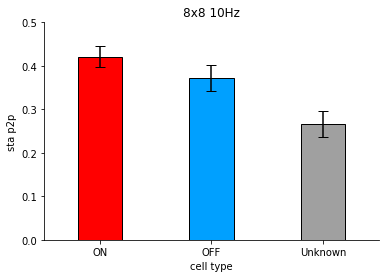

In [14]:
plot_bar_by_group(info0, 'sta_p2p',
                  group_values = group_values, color=color)

plt.ylim(0, 0.5)
plt.title(dataset0)
# plt.savefig("figure/sta/{}_p2p_bar.pdf".format(dataset), bbox_inches='tight')
# plt.savefig("figure/sta/{}_p2p_bar.png".format(dataset), bbox_inches='tight')

In [15]:
# test significance: ON or OFF vs. ON/OFF
data = groupby_dict(info0, 'sta_p2p', 'cell_type')

t, p = stats.ttest_ind(data['ON'], data['OFF'], equal_var=False)
print(p)

t, p = stats.ttest_ind(data['ON'] + data['OFF'], data['Unknown'], equal_var=False)
print(p)

0.21517341518832303
0.0006173642310534816


Text(0.5, 1.0, '26x26 10Hz')

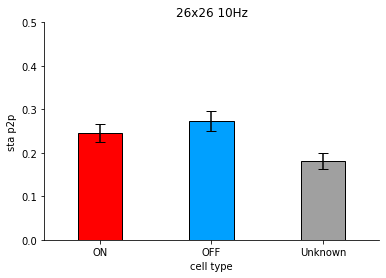

In [16]:
plot_bar_by_group(info1, 'sta_p2p',
                  group_values = group_values, color=color)

plt.ylim(0, 0.5)
plt.title(dataset1)
# plt.savefig("figure/sta/{}_p2p_bar.pdf".format(dataset), bbox_inches='tight')
# plt.savefig("figure/sta/{}_p2p_bar.png".format(dataset), bbox_inches='tight')

In [17]:
# test significance: ON or OFF vs. ON/OFF
data = groupby_dict(info1, 'sta_p2p', 'cell_type')

t, p = stats.ttest_ind(data['ON'], data['OFF'], equal_var=False)
print(p)

t, p = stats.ttest_ind(data['ON'] + data['OFF'], data['Unknown'], equal_var=False)
print(p)

0.35276577033689704
0.0016858513634830927
